In [12]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.stats import multivariate_normal
import seaborn as sns
sns.set()
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from tqdm import tqdm


In [10]:
@dataclass
class Params:
    pi: np.ndarray
    mu: list[np.ndarray]
    sigma: list[np.ndarray]

def params_generator(rng: np.random.Generator, D: int, K: int) -> Params:
    pi = rng.dirichlet(np.ones(K), size=1).reshape(K, )
    mu = rng.uniform(-10, 10, (K, D))
    sigma = [
        np.eye(D) * rng.uniform(1, 10)
        for _ in range(K)
    ]
    return Params(pi, mu, sigma)

def generate_sample_gm(rng: np.random.Generator, params: Params, N: int):
    D = params.mu[0].shape[0]
    K = params.mu.shape[0]
    z = rng.choice(K, size=N, p=params.pi)
    y = np.array([
        rng.multivariate_normal(params.mu[k], params.sigma[k])
        for k in z
    ])

    return np.concatenate(y, axis=0).reshape(N, D)


true: Params(pi=array([0.4371611 , 0.08570148, 0.18438848, 0.22552214, 0.0672268 ]), mu=array([[ 6.24189013,  8.46689996],
       [-4.46851204,  6.39509123],
       [ 7.79785386,  0.2594091 ],
       [-5.10070798,  6.48483192],
       [-5.72474073,  4.82934104]]), sigma=[array([[6.66946184, 0.        ],
       [0.        , 6.66946184]]), array([[9.34666533, 0.        ],
       [0.        , 9.34666533]]), array([[3.0871737, 0.       ],
       [0.       , 3.0871737]]), array([[8.19212616, 0.        ],
       [0.        , 8.19212616]]), array([[5.66348533, 0.        ],
       [0.        , 5.66348533]])])
estimated: Params(pi=array([0.16554044, 0.26906795, 0.17103018, 0.29232017, 0.10204125]), mu=array([[ 7.76215774,  6.8355453 ],
       [-4.47095798,  7.85934899],
       [ 7.62527017,  0.53435624],
       [ 5.6208972 ,  9.9092347 ],
       [-4.72678591,  2.24803397]]), sigma=array([[[ 3.13310303,  1.41670338],
        [ 1.41670338,  1.44025573]],

       [[ 9.0644872 , -2.01403608],
     

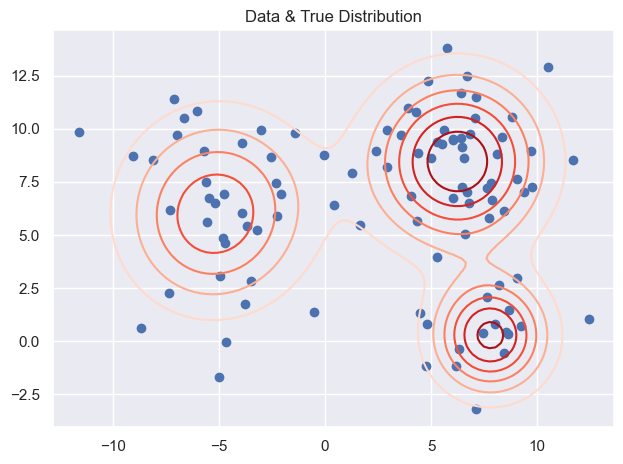

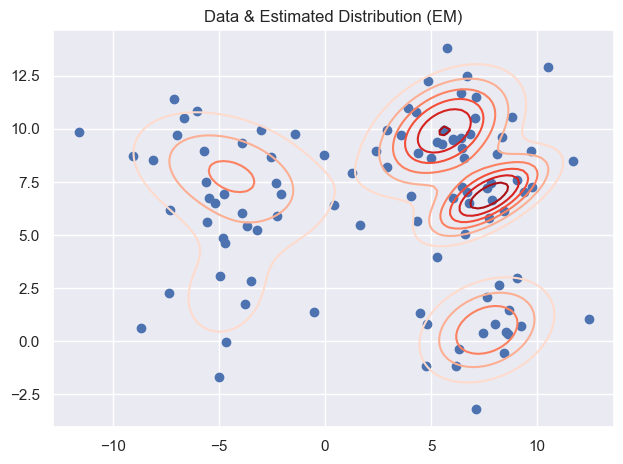

In [11]:
K = 5
N = 100
D = 2

rng = np.random.default_rng(123)

true_params = params_generator(rng, D, K)
data = generate_sample_gm(rng, true_params, N)
print(f"true: {true_params}")
fig, ax = plt.subplots()

if D == 1:
    # plot data
    sns.histplot(data, bins=30, ax=ax, stat='density')
    # plot true distribution
    x = np.linspace(*ax.get_xlim(), 100)
    density = np.zeros((len(x), ))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k])
    ax.plot(x, density, label="mixed density")
    for k in range(K):
        ax.plot(x, multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k]), label=f"component {k}")
    ax.legend()
    ax.set_title("Data & True Distribution")
    fig.tight_layout()
if D == 2:
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), true_params.mu[k], true_params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & True Distribution")
    fig.tight_layout()


params = GaussianMixture(n_components=K, random_state=123).fit(data)
params = Params(params.weights_, params.means_, params.covariances_)

print(f"estimated: {params}")


if D == 2:
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), params.mu[k], params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & Estimated Distribution (EM)")
    fig.tight_layout()




true: Params(pi=array([0.4371611 , 0.08570148, 0.18438848, 0.22552214, 0.0672268 ]), mu=array([[ 6.24189013,  8.46689996],
       [-4.46851204,  6.39509123],
       [ 7.79785386,  0.2594091 ],
       [-5.10070798,  6.48483192],
       [-5.72474073,  4.82934104]]), sigma=[array([[6.66946184, 0.        ],
       [0.        , 6.66946184]]), array([[9.34666533, 0.        ],
       [0.        , 9.34666533]]), array([[3.0871737, 0.       ],
       [0.       , 3.0871737]]), array([[8.19212616, 0.        ],
       [0.        , 8.19212616]]), array([[5.66348533, 0.        ],
       [0.        , 5.66348533]])])
estimated: Params(pi=array([4.54778717e-01, 3.63369343e-01, 1.80057226e-01, 1.53839783e-03,
       2.56316833e-04]), mu=array([[ 6.25922577,  8.81496834],
       [-4.44160207,  6.31811025],
       [ 7.1927754 ,  1.20515602],
       [ 2.54681353,  6.46382198],
       [ 2.54688493,  6.46371132]]), sigma=array([[[ 6.11482077,  0.03196559],
        [ 0.03196559,  4.51998557]],

       [[ 9.34

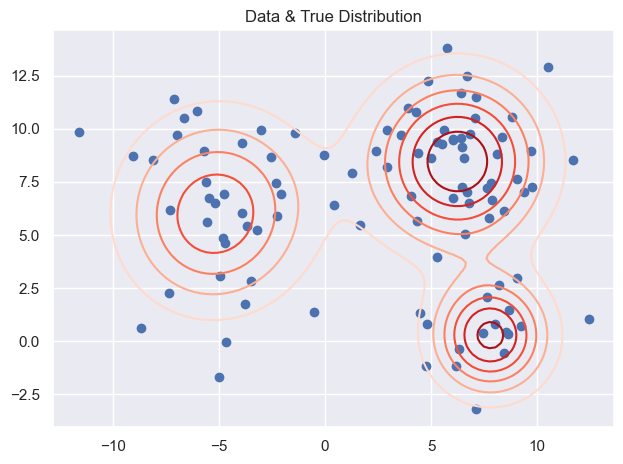

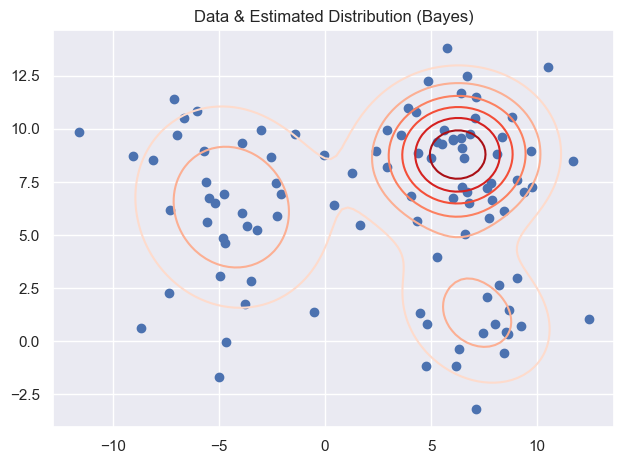

In [14]:
K = 5
N = 100
D = 2

rng = np.random.default_rng(123)

true_params = params_generator(rng, D, K)
data = generate_sample_gm(rng, true_params, N)
print(f"true: {true_params}")
fig, ax = plt.subplots()

if D == 1:
    # plot data
    sns.histplot(data, bins=30, ax=ax, stat='density')
    # plot true distribution
    x = np.linspace(*ax.get_xlim(), 100)
    density = np.zeros((len(x), ))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k])
    ax.plot(x, density, label="mixed density")
    for k in range(K):
        ax.plot(x, multivariate_normal.pdf(x, true_params.mu[k], true_params.sigma[k]), label=f"component {k}")
    ax.legend()
    ax.set_title("Data & True Distribution")
    fig.tight_layout()
if D == 2:
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += true_params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), true_params.mu[k], true_params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & True Distribution")
    fig.tight_layout()


params = BayesianGaussianMixture(n_components=K, random_state=123).fit(data)
params = Params(params.weights_, params.means_, params.covariances_)

print(f"estimated: {params}")


if D == 2:
    fig, ax = plt.subplots()
    # plot data
    ax.scatter(data[:, 0], data[:, 1])
    # plot true distribution
    x1 = np.linspace(*ax.get_xlim(), 100)
    x2 = np.linspace(*ax.get_ylim(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    density = np.zeros((len(x1), len(x2)))
    for k in range(K):
        density += params.pi[k] * multivariate_normal.pdf(np.stack([X1, X2], axis=2), params.mu[k], params.sigma[k])
    ax.contour(X1, X2, density, cmap='Reds')
    ax.set_title("Data & Estimated Distribution (Bayes)")
    fig.tight_layout()

